이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 네거티브 샘플링 구현하기 튜토리얼입니다.  

링크 : https://wikidocs.net/69141  

# 1. 20뉴스그룹 데이터 전처리하기

In [2]:
# 📦 데이터 처리를 위한 필수 라이브러리
import pandas as pd          # 표(데이터프레임) 형태로 데이터 읽기/정리/가공
import numpy as np           # 수치 계산(배열, 벡터/행렬 연산)에 특화

# 🧰 NLTK: 자연어 처리 도구 모음 (영어 텍스트 전처리에 많이 사용)
import nltk
from nltk.corpus import stopwords   # 불용어(자주 나오지만 의미 약한 단어) 목록 사용
# ※ 처음 한 번은 아래처럼 리소스를 내려받아야 합니다:
# nltk.download('stopwords')

# 📰 예제 텍스트 데이터셋(20개 뉴스 그룹)을 쉽게 불러오기
from sklearn.datasets import fetch_20newsgroups
# 예) newsgroups = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'))

# 🔤 텍스트를 정수 시퀀스로 바꾸는 Keras 토크나이저
from tensorflow.keras.preprocessing.text import Tokenizer
# 예) tok = Tokenizer(num_words=10000, oov_token="<OOV>")
#     tok.fit_on_texts(list_of_texts)         # 단어 사전 구축
#     seqs = tok.texts_to_sequences(texts)    # 텍스트 → 정수 시퀀스

In [3]:
# 📰 20 Newsgroups 데이터셋 불러오기

# fetch_20newsgroups()
# → 20개의 뉴스 카테고리(정치, 과학, 스포츠 등)로 구성된 대표적인 텍스트 분류용 데이터셋
#   예시: comp.graphics, sci.space, talk.politics.guns 등

dataset = fetch_20newsgroups(
    shuffle=True,                     # 데이터를 랜덤으로 섞어서 불러옴 (학습 편향 방지)
    random_state=1,                   # 랜덤 시드 고정 (실행할 때마다 결과가 동일하게)
    remove=('headers', 'footers', 'quotes')  # 뉴스 본문 외의 머리말, 꼬리말, 인용문 제거 → 순수한 본문만 남김
)

# dataset.data : 실제 뉴스 기사 텍스트가 담겨 있는 리스트
documents = dataset.data

# 전체 뉴스 기사 개수 출력
print('총 샘플 수 :', len(documents))

# ✅ 실행 예시:
# 총 샘플 수 : 11314

총 샘플 수 : 11314


In [4]:
# 🧹 뉴스 데이터 전처리 과정
#    불필요한 문자 제거 + 짧은 단어 삭제 + 소문자 통일

# 1️⃣ 원본 뉴스 데이터를 DataFrame 형태로 변환
news_df = pd.DataFrame({'document': documents})
# → 리스트 형태였던 뉴스 기사들을 표 형태로 바꿔줌 (컬럼명: document)

# 2️⃣ 특수문자 제거
# [^a-zA-Z] : 영어 대문자(A-Z), 소문자(a-z)를 제외한 모든 문자
# → 즉, 숫자·기호·특수문자·한글 등을 공백(" ")으로 바꿉니다.
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")

# 3️⃣ 짧은 단어(길이 ≤ 3) 제거
# 예: "the", "of", "and" 같은 짧은 단어들은 분석에 큰 의미가 없을 수 있음
# x.split() → 문장을 단어 단위로 나눔
# [w for w in x.split() if len(w) > 3] → 단어 길이가 4 이상인 단어만 남김
# ' '.join(...) → 다시 공백으로 연결해 문장 형태로 복원
news_df['clean_doc'] = news_df['clean_doc'].apply(
    lambda x: ' '.join([w for w in x.split() if len(w) > 3])
)

# 4️⃣ 모든 단어를 소문자로 변환
# 대소문자 차이로 같은 단어가 다르게 인식되는 문제를 방지
# 예: "Apple"과 "apple"을 모두 "apple"로 통일
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

# ✅ 결과 예시:
# 원문: "NASA Launches a New Space Mission!!!"
# 처리 후: "nasa launches space mission"

In [5]:
news_df.head()

,document,clean_doc
0,Well i'm not sure about the story nad it did s...,well sure about story seem biased. what disagr...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...","yeah, expect people read faq, etc. actually ac..."
2,Although I realize that principle is not one o...,although realize that principle your strongest...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding legitimate fuss about this pro...
4,"Well, I will have to change the scoring on my ...","well, will have change scoring playoff pool. u..."


In [6]:
# 현재 데이터프레임에 Null 값이 있는지 확인합니다.
news_df.isnull().values.any()

np.False_

In [7]:
# 빈 값(empy) 유무도 확인해야 합니다. 모든 빈 값을 Null 값으로 변환
news_df.replace("", float("NaN"), inplace=True)

In [8]:
# 다시 Null 값이 있는지 확인합니다.
news_df.isnull().values.any()

np.True_

In [9]:
# Null 값을 제거합니다.
news_df.dropna(inplace=True)

In [10]:
print(len(news_df))

11004


In [11]:
# 🧠 NLTK의 불용어(stopwords) 리스트를 이용해
#     뉴스 기사에서 의미 없는 단어들을 제거하는 단계

import nltk   # NLTK(자연어 처리용 기본 라이브러리) 불러오기

# 처음 한 번은 stopwords 데이터를 다운로드해야 함
nltk.download('stopwords')

# 1️⃣ 영어 불용어 리스트 불러오기
# stopwords.words('english')
# → 'the', 'is', 'at', 'which', 'on' 등 분석에 불필요한 단어 약 180개 포함
stop_words = stopwords.words('english')

# 2️⃣ 문장 단위 데이터를 단어 단위로 분리 (토큰화)
# x.split() → 공백 기준으로 단어를 분리
# 예: "nasa launches new mission" → ['nasa', 'launches', 'new', 'mission']
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# 3️⃣ 불용어 제거
# 리스트 컴프리헨션을 사용해 stop_words에 없는 단어만 남김
# 예: ['this', 'is', 'a', 'news', 'article'] → ['news', 'article']
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# ✅ 실행 결과 예시:
# 원문: "this is a new space mission"
# 처리 후: ['new', 'space', 'mission']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 📋 pandas Series → Python 리스트(list)로 변환하는 코드

# tokenized_doc 은 현재 pandas Series 형태입니다.
# (즉, 각 행마다 하나의 토큰화된 문장 리스트가 들어 있는 상태)
# 예시:
# 0    ['nasa', 'launches', 'new', 'mission']
# 1    ['computer', 'graphics', 'design']
# 2    ['politics', 'gun', 'debate']
# dtype: object

# .to_list() 메서드는 pandas Series를 일반 Python 리스트로 변환합니다.
# 변환 후 형태:
# [
#   ['nasa', 'launches', 'new', 'mission'],
#   ['computer', 'graphics', 'design'],
#   ['politics', 'gun', 'debate'],
#   ...
# ]

tokenized_doc = tokenized_doc.to_list()

# ✅ 이렇게 하면 이후 Word2Vec, LDA 등 모델 학습 시
#    tokenized_doc을 바로 입력 데이터로 사용할 수 있습니다.

In [12]:
# ⚠️ Word2Vec 같은 모델을 학습할 때는
#     한 문장에 단어가 최소 2개 이상 있어야 ‘중심 단어(center word)’와 ‘주변 단어(context word)’ 관계를 학습할 수 있습니다.
#     단어가 1개 이하인 문장은 학습에 사용할 수 없으므로 제거 대상입니다.

# enumerate(tokenized_doc)
# → tokenized_doc의 각 문장을 (인덱스, 문장) 형태로 반복
#   예: [(0, ['nasa', 'launches', 'mission']), (1, ['computer']), (2, ['ai', 'model']), ...]

# if len(sentence) <= 1
# → 문장에 포함된 단어 개수가 1개 이하인 경우 True

# [index for index, sentence in ... if ...]
# → 조건에 맞는 문장들의 인덱스만 모아 리스트로 저장

drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]

# ✅ 실행 결과 예시:
# drop_train = [15, 78, 131, 252, ...]
# (→ 1개 이하 단어만 있는 문장들의 인덱스 번호가 리스트로 저장됨)

In [13]:
print(drop_train)

[44, 353, 486, 1224, 1653, 2323, 2373, 2864, 3292, 3389, 3397, 3398, 3562, 3567, 3595, 3784, 3879, 4185, 4592, 4622, 4952, 4975, 5395, 5530, 6020, 6657, 6728, 6888, 7085, 7961, 8161, 8217, 8288, 8422, 8594, 8627, 9703, 10283, 10447, 10738, 10758, 10904, 10916, 10964]


In [14]:
# 🧹 단어가 1개 이하인 문장(학습 불가능한 샘플)을 실제로 제거하는 코드

# np.delete(배열, 인덱스리스트, axis=0)
# → 지정된 인덱스의 행(row)을 삭제하는 함수
#   - tokenized_doc : 우리가 학습에 사용할 문장들의 리스트
#   - drop_train : 앞 단계에서 찾은 “단어가 1개 이하인 문장”의 인덱스 목록
#   - axis=0 : 행(문장) 단위로 삭제

tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)

# ✅ 실행 결과:
# tokenized_doc에는 이제 “단어가 2개 이상 있는 문장”만 남게 됩니다.
# 예)
# 제거 전: [['ai'], ['deep', 'learning'], ['space', 'nasa']]
# 제거 후: [['deep', 'learning'], ['space', 'nasa']]

In [15]:
print(len(tokenized_doc))

10960


In [16]:
# 🔢 단어 집합(Vocabulary)을 만들고, 각 단어를 정수로 바꾸는 과정

# 1️⃣ Tokenizer 객체 생성
# Tokenizer() → Keras에서 제공하는 단어 인덱싱 도구
# 문장에 등장하는 단어들을 자동으로 숫자(정수)로 매핑해 줍니다.
tokenizer = Tokenizer()

# 2️⃣ 단어 사전(Vocabulary) 생성
# fit_on_texts(tokenized_doc)
# → tokenized_doc의 모든 단어를 읽고 단어 빈도(frequency)에 따라 인덱스를 부여
#    (가장 자주 등장한 단어일수록 번호가 작게 부여됨)
tokenizer.fit_on_texts(tokenized_doc)

# 3️⃣ word2idx : 단어 → 숫자 인덱스 딕셔너리
# 예: {'the': 1, 'and': 2, 'data': 3, ...}
word2idx = tokenizer.word_index

# 4️⃣ idx2word : 숫자 인덱스 → 단어 역변환 딕셔너리
# (딥러닝 모델 결과 해석할 때 유용)
# 예: {1: 'the', 2: 'and', 3: 'data', ...}
idx2word = {value: key for key, value in word2idx.items()}

# 5️⃣ 문장별로 단어를 숫자 시퀀스로 변환
# texts_to_sequences()
# → 각 문장을 단어 인덱스 번호로 변환
# 예: [['data', 'science', 'rocks']] → [[3, 12, 45]]
encoded = tokenizer.texts_to_sequences(tokenized_doc)

# ✅ 실행 결과 예시:
# tokenized_doc[0]  → ['nasa', 'launches', 'new', 'mission']
# encoded[0]        → [27, 103, 4, 87]

In [17]:
# 상위 2개의 샘플을 출력해봅시다.
print(encoded[:2])

[[39, 52, 921, 141, 15874, 1675, 541, 275, 865, 12013, 17757, 23990, 29709, 275, 865, 63418, 865, 1121, 1096, 1988, 845, 29710, 907, 726, 20460, 275, 865, 168, 141, 1802, 147, 275, 20461, 17757, 6631, 5696, 75, 63419, 7, 35, 163, 609, 648, 29711, 6897, 23991, 2072, 823, 17758, 1112, 8776, 350, 1065, 15875, 666, 56, 161, 4217, 7192, 1924, 435, 55, 278, 4716, 9261, 2679, 39289], [1276, 424, 3, 51, 6150, 157, 111, 469, 88, 17759, 18, 62, 4717, 2854, 63420, 1035, 397, 39290, 8777, 896, 43, 8314, 312, 13026, 896, 3439, 5909, 528, 18, 86, 4718, 9858, 158, 1395, 119, 149, 5180, 63421, 63422, 17760, 63423, 13026, 897, 63424, 63425, 11157, 17761]]


In [18]:
# 단어 집합의 크기를 확인합니다.
vocab_size = len(word2idx) + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 181822


# 네거티브 샘플링을 통한 데이터셋 구성하기

In [27]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# ✅ 1) 안전한 하이퍼파라미터(정수 강제)
vocab_size = int(len(word2idx) + 1)   # Tokenizer 인덱스가 1부터 시작하므로 +1
window_size = int(10)                  # 혹시 10.0 등으로 들어갔다면 정수로 강제

# ✅ 2) 시퀀스가 '정수 리스트'인지 점검 (넘파이 타입/float 섞임 방지)
encoded_int = [list(map(int, seq)) for seq in encoded[:10]]

# ✅ 3) skip-gram 쌍 생성 (네거티브 샘플 포함)
skip_grams = [
    skipgrams(
        sequence=sample,
        vocabulary_size=vocab_size,
        window_size=window_size,   # 반드시 int
        negative_samples=1.0,      # float OK
        shuffle=True,
        seed=42
    )
    for sample in encoded_int
]

# ✅ 4) 첫 번째 샘플 확인 (키 없을 때 대비해 get 사용)
pairs, labels = skip_grams[0]
n_show = min(5, len(pairs))
for i in range(n_show):
    w_i, w_j = pairs[i]
    wi = idx2word.get(w_i, "<OOV>")
    wj = idx2word.get(w_j, "<OOV>")
    print(f"({wi} ({w_i}), {wj} ({w_j})) -> {int(labels[i])}")

(least (75), reason (163)) -> 1
(subsidizing (20461), ;>duck. (179787)) -> 0
(described (907), them. (147)) -> 1
(u.s. (275), degree). (63419)) -> 1
(shame (6897), think (7)) -> 1


In [28]:
print(len(skip_grams))

10


In [29]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2460
2460


In [31]:
# 위의 작업을 모든 뉴스그룹 샘플에 대해서 수행합니다. (2분 정도 소요)

# ✅ 1) 안전한 하이퍼파라미터 (정수로 강제)
vocab_size = int(len(word2idx) + 1)   # Tokenizer 인덱스가 1부터 시작 → +1
WIN = int(10)                         # window_size는 반드시 int 여야 함

# ✅ 2) 시퀀스 정리: float 섞임/빈 시퀀스 방지 (최소 2토큰만 사용)
encoded_int = [list(map(int, seq)) for seq in encoded if len(seq) > 1]

# ✅ 3) 전체 문장에 대해 skip-gram 생성 (네거티브 샘플 포함)
skip_grams = [
    skipgrams(
        sequence=seq,                         # 정수 리스트
        vocabulary_size=int(vocab_size),      # 반드시 int
        window_size=WIN,                      # 반드시 int
        negative_samples=1.0,                 # float OK
        shuffle=True,
        seed=42
    )
    for seq in encoded_int
]

# ✅ 4) 예시 출력 (첫 문장만 살펴보기)
pairs, labels = skip_grams[0]
for i in range(min(5, len(pairs))):
    w_i, w_j = pairs[i]
    wi = idx2word.get(w_i, "<OOV>")
    wj = idx2word.get(w_j, "<OOV>")
    print(f"({wi} ({w_i}), {wj} ({w_j})) -> {int(labels[i])}")

(least (75), reason (163)) -> 1
(incidences (29710), $1200-1300 (41687)) -> 0
(described (907), them. (147)) -> 1
(u.s. (275), degree). (63419)) -> 1
(shame (6897), think (7)) -> 1


# 2. Skip-Gram with Negative Sampling(SGNS) 구현하기

In [32]:
# 🧠 Word2Vec(혹은 딥러닝 모델)을 만들기 위한 Keras 모듈 불러오기

# 모델 구조를 순차적으로 쌓는 방식(Sequential) 또는 사용자 정의(Model) 방식 둘 다 사용 가능
from tensorflow.keras.models import Sequential, Model

# 신경망을 구성하는 층(Layer) 불러오기
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot

# Embedding : 단어를 벡터(숫자 표현)로 바꾸는 층 (Word2Vec의 핵심)
# Reshape   : 벡터나 행렬의 형태(차원)를 바꾸는 층
# Activation : 활성화 함수 (예: sigmoid, relu 등)
# Input      : 입력 데이터를 정의할 때 사용
# Dot        : 두 벡터의 내적(dot product)을 계산 (Word2Vec에서는 단어 유사도 계산용)

# 모델 구조를 시각화(그림)해주는 함수
from tensorflow.keras.utils import plot_model

# Colab/Jupyter에서 모델 구조 이미지를 직접 표시하기 위한 도구
from IPython.display import SVG

In [33]:
# 하이퍼파라미터인 임베딩 벡터의 차원은 100으로 정함
embedding_dim = 100

In [34]:
# 🎯 Word2Vec(특히 Skip-gram) 모델의 핵심 아이디어:
#    "중심 단어(center word)"와 "주변 단어(context word)"를 각각 임베딩 벡터로 표현하고,
#    두 벡터의 유사도를 학습하는 구조를 만듭니다.

# ✅ 1️⃣ 중심 단어 입력 (Input Layer)
w_inputs = Input(shape=(1, ), dtype='int32')
# - shape=(1,) : 한 번에 하나의 단어(정수 인덱스)만 입력받음
# - dtype='int32' : 입력값은 정수형(단어 인덱스 번호)
# 예시: "book" → [1532]  (1532번 단어)

# ✅ 2️⃣ 중심 단어 임베딩 (Embedding Layer)
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)
# - Embedding(vocab_size, embedding_dim)
#   : 단어 인덱스를 embedding_dim 크기의 벡터로 변환
#   예) vocab_size=10000, embedding_dim=100 → 각 단어를 100차원 벡터로 표현
# - (w_inputs)을 괄호 안에 넣어서 실제 입력 데이터에 적용
#   결과: "book" → [0.13, -0.25, 0.48, ...] (100차원 벡터)

# ✅ 3️⃣ 주변 단어 입력 (Input Layer)
c_inputs = Input(shape=(1, ), dtype='int32')
# - 중심 단어와 동일하게, 주변 단어의 인덱스를 입력받음
# 예시: "library" → [4127]

# ✅ 4️⃣ 주변 단어 임베딩 (Embedding Layer)
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)
# - 중심 단어 임베딩과는 ‘독립된’ 임베딩 테이블 (Word2Vec 구조상 2개 사용)
# - 결과: "library" → [-0.07, 0.22, 0.35, ...] (100차원 벡터)

In [35]:
# 🧠 Word2Vec(Skip-gram) 학습 아이디어:
# 중심 단어 벡터와 주변 단어 벡터의 내적(dot product)을 통해 두 단어의 관련성을 계산하고,
# 그 결과를 시그모이드 함수를 통해 0~1 사이의 확률로 변환하여 “같은 문맥에 등장할 확률”을 예측합니다.

# ✅ 1️⃣ 두 임베딩 벡터의 내적(Dot Product)
dot_product = Dot(axes=2)([word_embedding, context_embedding])
# - 중심 단어 임베딩과 주변 단어 임베딩은 각각 (batch_size, 1, embedding_dim) 형태
# - Dot(axes=2)는 두 벡터의 마지막 차원(embedding_dim)을 기준으로 내적 수행
#   → 결과는 (batch_size, 1, 1) 형태의 스칼라 값이 됨
#   예: 중심 단어("book")와 주변 단어("library")의 유사도 계산

# ✅ 2️⃣ Reshape : 차원 변환
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
# - (batch_size, 1, 1) → (batch_size, 1)
# - Keras의 Dense 층 등과 호환되도록 차원을 정리하는 단계

# ✅ 3️⃣ 시그모이드 활성화 함수 (Sigmoid Activation)
output = Activation('sigmoid')(dot_product)
# - 내적 결과를 0~1 사이 확률로 변환
#   → 1에 가까울수록 “두 단어가 같은 문맥에 함께 등장할 확률이 높다”
#   → 0에 가까울수록 “문맥상 관련이 적다”
# - Word2Vec의 Skip-gram with Negative Sampling(SGNS) 학습 구조에서 핵심 역할

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │ 18,182,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │ 18,182,200 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 1)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1)         │          0 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ reshape[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,364,400 (138.72 MB)

 Trainable params: 36,364,400 (138.72 MB)

 Non-trainable params: 0 (0.00 B)

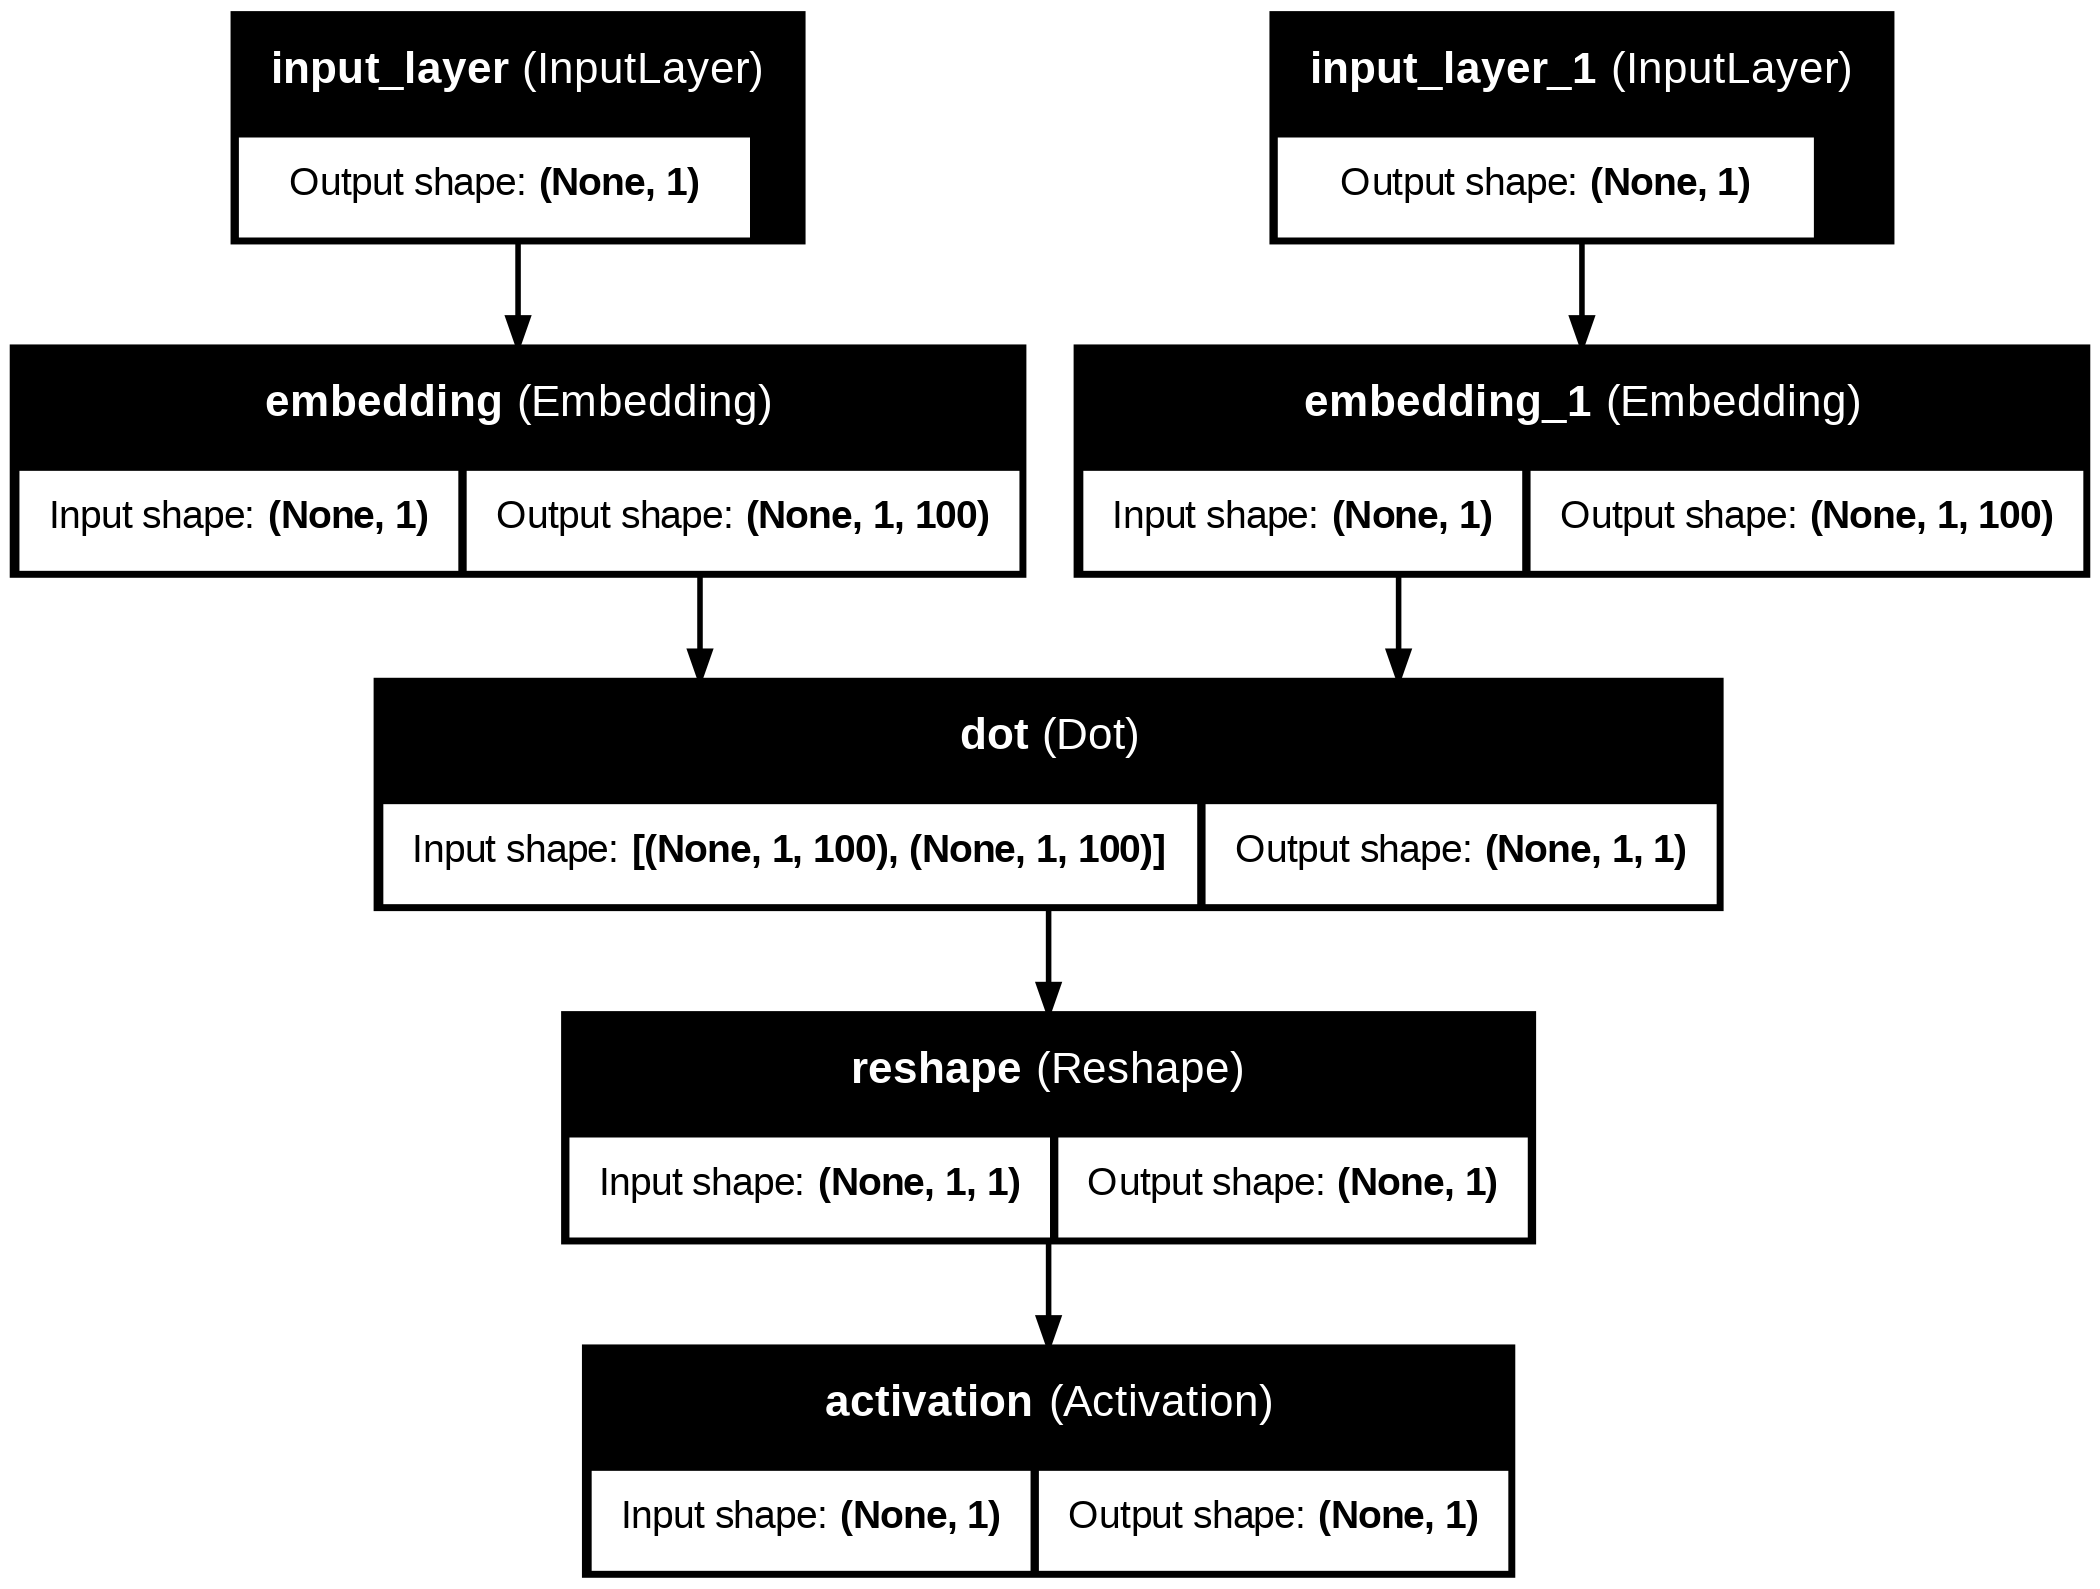

In [36]:
# 🧩 Word2Vec(Skip-gram) 구조를 실제 Keras 모델로 완성하고 요약, 시각화하는 단계

# ✅ 1️⃣ 모델 구성 (Functional API 방식)
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
# - 입력: 중심 단어(w_inputs), 주변 단어(c_inputs)
# - 출력: 두 단어가 같은 문맥에 있을 확률 (0~1)
# → 지금까지 정의한 모든 층(Input, Embedding, Dot, Activation)을 하나의 모델로 묶음

# ✅ 2️⃣ 모델 구조 요약
model.summary()
# - 각 층의 이름, 출력 형태(shape), 파라미터 수(parameter count)를 출력
# 예시 출력:
# ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
# ┃ Layer (type)          ┃ Output Shape   ┃ Param #     ┃
# ┣━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━┫
# ┃ embedding (Embedding) ┃ (None, 1, 100) ┃ 1,000,000   ┃
# ┃ dot (Dot)             ┃ (None, 1, 1)   ┃ 0           ┃
# ┃ activation (Sigmoid)  ┃ (None, 1)      ┃ 0           ┃
# ┗━━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┛
# Total params: 어휘 수 × 임베딩 차원 수 × 2

# ✅ 3️⃣ 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam')
# - 손실 함수(loss): binary_crossentropy (0 또는 1을 맞추는 이진 분류용)
# - 옵티마이저(optimizer): adam (학습 효율이 좋은 대표적인 알고리즘)
# → Skip-gram은 "같은 문맥인지(1)" vs "아닌지(0)"를 분류하는 문제이므로 이진 손실 사용

# ✅ 4️⃣ 모델 시각화
plot_model(model,
           to_file='skip_gram.png',           # 저장 파일명
           show_shapes=True,                  # 각 층의 입출력 shape 표시
           show_layer_names=True,             # 층 이름 표시
           rankdir='TB')                      # 모델 다이어그램 방향 (Top-Bottom)

# 🔍 실행 후:
# - 'skip_gram.png' 파일로 Word2Vec(Skip-gram) 네트워크 구조가 저장됩니다.
# - Colab 환경에서는 "files" 탭 또는 다운로드 버튼으로 확인 가능.

In [ ]:
# 🧠 Skip-gram Word2Vec 모델 학습 단계
# - 중심 단어와 주변 단어 쌍(양성, 음성 샘플 포함)을 이용해 학습
# - 총 5 epoch(5회 반복) 동안 학습을 수행
# ⚠️ 데이터 크기에 따라 학습 시간이 상당히 오래 걸릴 수 있습니다.

for epoch in range(1, 6):   # 1~5 epoch 반복
    loss = 0                # epoch별 손실(loss) 합계를 저장할 변수 초기화

    # skip_grams : 각 문장마다 생성된 (단어 쌍, 레이블) 데이터 리스트
    for _, elem in enumerate(skip_grams):
        # elem[0] → (중심 단어, 주변 단어) 쌍들의 리스트
        # elem[1] → 각 쌍의 정답 레이블 (1=같은 문맥, 0=무관한 단어)

        # 중심 단어와 주변 단어 쌍을 각각 numpy 배열로 분리
        # zip(*elem[0]) → [(w1, c1), (w2, c2), ...] → ([w1, w2, ...], [c1, c2, ...])
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')   # 중심 단어
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')  # 주변 단어
        labels = np.array(elem[1], dtype='int32')                      # 1 또는 0 레이블

        # X = 입력 (중심 단어, 주변 단어), Y = 정답 (문맥 여부)
        X = [first_elem, second_elem]
        Y = labels

        # 🔁 한 배치(batch)씩 모델 학습 (train_on_batch)
        # - 전체 데이터를 한 번에 학습하지 않고, 문장 단위로 조금씩 학습
        # - 반환값은 해당 배치의 손실값(loss)
        loss += model.train_on_batch(X, Y)

    # 에포크별 평균 손실값 출력
    print('Epoch :', epoch, 'Loss :', loss)

# 3. 결과 확인하기

In [ ]:
import gensim

In [ ]:
# 학습된 임베딩 벡터들을 vector.txt에 저장합니다.
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
# 저장된 임베딩 벡터를  gensim의 models.KeyedVectors.load_word2vec_format()으로 로드하면
# 쉽게 단어 벡터 간 유사도를 구할 수 있습니다.
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['disease'])

[('infection', 0.6822181940078735),
 ('patients', 0.6786915063858032),
 ('diseases', 0.6778280138969421),
 ('yeast', 0.637976348400116),
 ('lyme', 0.6234785318374634),
 ('lesions', 0.62334144115448),
 ('treat', 0.6229036450386047),
 ('nerve', 0.6226518750190735),
 ('quack', 0.6102176308631897),
 ('chronic', 0.6035628318786621)]

In [ ]:
w2v.most_similar(positive=['soldiers'])

[('wounded', 0.7870566248893738),
 ('hamas', 0.780727744102478),
 ('slaughter', 0.778682291507721),
 ('massacred', 0.7761104702949524),
 ('palestinians', 0.7727225422859192),
 ('villages', 0.7700804471969604),
 ('shelling', 0.7644733190536499),
 ('occupation', 0.7623903751373291),
 ('terrorist', 0.7594828009605408),
 ('killed', 0.7571672201156616)]

In [ ]:
w2v.most_similar(positive=['police'])

[('officers', 0.5940332412719727),
 ('demand', 0.5538086295127869),
 ('investigation', 0.5475316047668457),
 ('permit', 0.5427597761154175),
 ('homes', 0.5251521468162537),
 ('intifada', 0.5153162479400635),
 ('switzerland', 0.5054680109024048),
 ('handguns', 0.5039469003677368),
 ('funds', 0.49640247225761414),
 ('treasury', 0.49368804693222046)]

In [ ]:
w2v.most_similar(positive=['hero'])

[('evident', 0.6241123676300049),
 ('treasury', 0.622967004776001),
 ('exercised', 0.6084901094436646),
 ('delegated', 0.6084328889846802),
 ('bloodshed', 0.605443000793457),
 ('restitution', 0.6043845415115356),
 ('gross', 0.6000478863716125),
 ('intervened', 0.5970805883407593),
 ('dashnaks', 0.594544529914856),
 ('verbally', 0.594032347202301)]

In [ ]:
w2v.most_similar(positive=['engine'])

[('wheel', 0.5794666409492493),
 ('honda', 0.5051121711730957),
 ('metal', 0.48657843470573425),
 ('pickup', 0.48521116375923157),
 ('smaller', 0.4837951362133026),
 ('front', 0.4800146818161011),
 ('brake', 0.4778139591217041),
 ('steering', 0.4674001634120941),
 ('shafts', 0.46222877502441406),
 ('rebuilt', 0.4620116949081421)]

In [ ]:
w2v.most_similar(positive=['doctor'])

[('pain', 0.6648697853088379),
 ('migraine', 0.632205605506897),
 ('prescription', 0.6129752397537231),
 ('spite', 0.5851105451583862),
 ('doctors', 0.5646334290504456),
 ('disease', 0.5567648410797119),
 ('mild', 0.5515984296798706),
 ('treatment', 0.5462743043899536),
 ('chronic', 0.5447998046875),
 ('quack', 0.5412765741348267)]